In [1]:
!pip install kaggle --upgrade --quiet

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!kaggle datasets download -d "dansbecker/food-101" -p "/content/drive/MyDrive/KaggleDatasets/food-101"

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.38G/9.38G [02:02<00:00, 86.8MB/s]
100% 9.38G/9.38G [02:02<00:00, 82.0MB/s]


In [5]:
!unzip "/content/drive/MyDrive/KaggleDatasets/food-101/food-101.zip"

Streaming output truncated to the last 5000 lines.
  inflating: food-101/food-101/images/tacos/1030289.jpg  
  inflating: food-101/food-101/meta/train.json  
  inflating: food-101/food-101/meta/train.txt  


In [6]:
import random

class Food101Dataset(Dataset):
    def __init__(self, dataset_directory, split, transform=None, max_image_count=None):

        self.dataset_directory = dataset_directory
        self.image_directory = os.path.join(dataset_directory, "images")
        self.transform = transform

        #Load the split file(either gonna be train or test)
        split_file = os.path.join(dataset_directory, f"meta/{split}.txt")
        with open(split_file, "r") as file:
            self.img_paths = file.read().splitlines()

        #Limit dataset (10k instead of 100k)
        if max_image_count is not None:
            self.img_paths = random.sample(self.img_paths, min(max_image_count, len(self.img_paths)))

        #Load class names
        class_file = os.path.join(dataset_directory, "meta/classes.txt")
        with open(class_file, "r") as file:
            self.classes = file.read().splitlines()

        #Map class names to numeric labels
        self.class_index_mapping = {}
        for index, cls_name in enumerate(self.classes):
            self.class_index_mapping[cls_name] = index

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        relative_path = self.img_paths[index]
        class_name = os.path.dirname(relative_path)
        label = self.class_index_mapping[class_name]

        img_path = os.path.join(self.image_directory, relative_path + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# For test/validation, only resizing and normalization
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_directory = "/content/food-101/food-101"
train_dataset = Food101Dataset(dataset_directory="/content/food-101/food-101", split="train", transform=train_transforms, max_image_count=8000)
test_dataset = Food101Dataset(dataset_directory="/content/food-101/food-101", split="test", transform=test_transforms, max_image_count=2000)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Number of classes: 101
Train samples: 8000
Test samples: 2000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#load up resnet
model = models.resnet50(pretrained=True)

# freeze base model layers, keeps pre-trained features from imagenet
for param in model.parameters():
    param.requires_grad = False

#replace the final layer for Food101 classes instead of the 1000 in imagenet
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


In [9]:
from tqdm import tqdm  # for the loadingbar

def train_one_epoch(model, loader, criterion, optimizer, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm progress bar
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch [{epoch}/{total_epochs}]")

    for batch_index, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        loss.backward()
        optimizer.step()

        #Save info
        running_loss += loss.item() * images.size(0)
        _, predictions = outputs.max(1)
        correct += predictions.eq(labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Batch Loss": loss.item(),
            "Running Loss": running_loss / total,
            "Accuracy": 100.0 * correct / total
        })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()  # Set model to evaluation mode, consistent behavior
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  #No need to track gradients during evaluation
        for images, labels in loader: # go through batches
            images, labels = images.to(device), labels.to(device) # move to right device
            outputs = model(images) # predict current batch
            loss = criterion(outputs, labels) #calc loss

            running_loss += loss.item() * images.size(0)
            _, predictions = outputs.max(1)
            correct += predictions.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
#Metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_acc = 0.0
# training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, "best_model_checkpoint.pth")

Epoch [1/30]: 100%|██████████| 250/250 [01:03<00:00,  3.93it/s, Batch Loss=3.23, Running Loss=3.88, Accuracy=17]


Epoch 1/30:
Train Loss: 3.8795, Train Acc: 0.1700
Val Loss: 2.9527, Val Acc: 0.3255


Epoch [2/30]: 100%|██████████| 250/250 [01:17<00:00,  3.21it/s, Batch Loss=1.88, Running Loss=2.75, Accuracy=35.7]


Epoch 2/30:
Train Loss: 2.7471, Train Acc: 0.3568
Val Loss: 2.4972, Val Acc: 0.3925


Epoch [3/30]: 100%|██████████| 250/250 [00:50<00:00,  4.91it/s, Batch Loss=2.92, Running Loss=2.38, Accuracy=42.4]


Epoch 3/30:
Train Loss: 2.3817, Train Acc: 0.4241
Val Loss: 2.4231, Val Acc: 0.4075


Epoch [4/30]: 100%|██████████| 250/250 [00:48<00:00,  5.14it/s, Batch Loss=2.09, Running Loss=2.22, Accuracy=44.7]


Epoch 4/30:
Train Loss: 2.2224, Train Acc: 0.4474
Val Loss: 2.3261, Val Acc: 0.4280


Epoch [5/30]: 100%|██████████| 250/250 [01:04<00:00,  3.87it/s, Batch Loss=2.22, Running Loss=2.09, Accuracy=47.3]


Epoch 5/30:
Train Loss: 2.0916, Train Acc: 0.4731
Val Loss: 2.3521, Val Acc: 0.4155


Epoch [6/30]: 100%|██████████| 250/250 [01:19<00:00,  3.16it/s, Batch Loss=1.98, Running Loss=2.01, Accuracy=49]


Epoch 6/30:
Train Loss: 2.0097, Train Acc: 0.4896
Val Loss: 2.3298, Val Acc: 0.4270


Epoch [7/30]: 100%|██████████| 250/250 [00:48<00:00,  5.21it/s, Batch Loss=2.01, Running Loss=1.95, Accuracy=50.3]


Epoch 7/30:
Train Loss: 1.9466, Train Acc: 0.5029
Val Loss: 2.2328, Val Acc: 0.4380


Epoch [8/30]: 100%|██████████| 250/250 [00:57<00:00,  4.37it/s, Batch Loss=1.67, Running Loss=1.91, Accuracy=51.3]


Epoch 8/30:
Train Loss: 1.9111, Train Acc: 0.5132
Val Loss: 2.3313, Val Acc: 0.4230


Epoch [9/30]: 100%|██████████| 250/250 [01:25<00:00,  2.92it/s, Batch Loss=2.18, Running Loss=1.84, Accuracy=52.5]


Epoch 9/30:
Train Loss: 1.8430, Train Acc: 0.5251
Val Loss: 2.2822, Val Acc: 0.4545


Epoch [10/30]: 100%|██████████| 250/250 [00:49<00:00,  5.08it/s, Batch Loss=2.28, Running Loss=1.82, Accuracy=52.8]


Epoch 10/30:
Train Loss: 1.8216, Train Acc: 0.5278
Val Loss: 2.2872, Val Acc: 0.4495


Epoch [11/30]: 100%|██████████| 250/250 [00:51<00:00,  4.85it/s, Batch Loss=2.15, Running Loss=1.78, Accuracy=53]


Epoch 11/30:
Train Loss: 1.7756, Train Acc: 0.5301
Val Loss: 2.3167, Val Acc: 0.4375


Epoch [12/30]: 100%|██████████| 250/250 [01:10<00:00,  3.53it/s, Batch Loss=1.56, Running Loss=1.72, Accuracy=55.4]


Epoch 12/30:
Train Loss: 1.7208, Train Acc: 0.5541
Val Loss: 2.2540, Val Acc: 0.4500


Epoch [13/30]: 100%|██████████| 250/250 [01:05<00:00,  3.82it/s, Batch Loss=1.96, Running Loss=1.71, Accuracy=55.1]


Epoch 13/30:
Train Loss: 1.7083, Train Acc: 0.5507
Val Loss: 2.3657, Val Acc: 0.4315


Epoch [14/30]: 100%|██████████| 250/250 [00:48<00:00,  5.15it/s, Batch Loss=1.79, Running Loss=1.67, Accuracy=56.3]


Epoch 14/30:
Train Loss: 1.6720, Train Acc: 0.5634
Val Loss: 2.3285, Val Acc: 0.4525


Epoch [15/30]: 100%|██████████| 250/250 [00:48<00:00,  5.17it/s, Batch Loss=1.85, Running Loss=1.65, Accuracy=55.9]


Epoch 15/30:
Train Loss: 1.6549, Train Acc: 0.5593
Val Loss: 2.4854, Val Acc: 0.4185


Epoch [16/30]: 100%|██████████| 250/250 [01:31<00:00,  2.74it/s, Batch Loss=1.4, Running Loss=1.65, Accuracy=55.9]


Epoch 16/30:
Train Loss: 1.6473, Train Acc: 0.5593
Val Loss: 2.2563, Val Acc: 0.4515


Epoch [17/30]: 100%|██████████| 250/250 [00:48<00:00,  5.18it/s, Batch Loss=1.06, Running Loss=1.58, Accuracy=58.1]


Epoch 17/30:
Train Loss: 1.5816, Train Acc: 0.5809
Val Loss: 2.3179, Val Acc: 0.4540


Epoch [18/30]: 100%|██████████| 250/250 [00:48<00:00,  5.20it/s, Batch Loss=2.47, Running Loss=1.59, Accuracy=57.9]


Epoch 18/30:
Train Loss: 1.5946, Train Acc: 0.5790
Val Loss: 2.3725, Val Acc: 0.4420


Epoch [19/30]: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s, Batch Loss=1.41, Running Loss=1.57, Accuracy=57.3]


Epoch 19/30:
Train Loss: 1.5722, Train Acc: 0.5734
Val Loss: 2.3880, Val Acc: 0.4425


Epoch [20/30]: 100%|██████████| 250/250 [00:47<00:00,  5.21it/s, Batch Loss=1.96, Running Loss=1.56, Accuracy=58.6]


Epoch 20/30:
Train Loss: 1.5634, Train Acc: 0.5861
Val Loss: 2.4612, Val Acc: 0.4330


Epoch [21/30]: 100%|██████████| 250/250 [00:48<00:00,  5.19it/s, Batch Loss=1.74, Running Loss=1.55, Accuracy=57.8]


Epoch 21/30:
Train Loss: 1.5542, Train Acc: 0.5779
Val Loss: 2.3533, Val Acc: 0.4565


Epoch [22/30]: 100%|██████████| 250/250 [01:19<00:00,  3.13it/s, Batch Loss=1.3, Running Loss=1.49, Accuracy=59.5]


Epoch 22/30:
Train Loss: 1.4932, Train Acc: 0.5949
Val Loss: 2.3524, Val Acc: 0.4435


Epoch [23/30]: 100%|██████████| 250/250 [00:58<00:00,  4.27it/s, Batch Loss=1.36, Running Loss=1.5, Accuracy=59.6]


Epoch 23/30:
Train Loss: 1.4977, Train Acc: 0.5965
Val Loss: 2.4314, Val Acc: 0.4375


Epoch [24/30]: 100%|██████████| 250/250 [00:48<00:00,  5.13it/s, Batch Loss=2.24, Running Loss=1.49, Accuracy=60.2]


Epoch 24/30:
Train Loss: 1.4889, Train Acc: 0.6020
Val Loss: 2.3286, Val Acc: 0.4525


Epoch [25/30]: 100%|██████████| 250/250 [01:13<00:00,  3.39it/s, Batch Loss=1.21, Running Loss=1.47, Accuracy=60.2]


Epoch 25/30:
Train Loss: 1.4652, Train Acc: 0.6020
Val Loss: 2.4694, Val Acc: 0.4370


Epoch [26/30]: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s, Batch Loss=1.2, Running Loss=1.46, Accuracy=60.2]


Epoch 26/30:
Train Loss: 1.4635, Train Acc: 0.6020
Val Loss: 2.3232, Val Acc: 0.4605


Epoch [27/30]: 100%|██████████| 250/250 [00:49<00:00,  5.09it/s, Batch Loss=0.958, Running Loss=1.44, Accuracy=61.2]


Epoch 27/30:
Train Loss: 1.4365, Train Acc: 0.6118
Val Loss: 2.4359, Val Acc: 0.4355


Epoch [28/30]: 100%|██████████| 250/250 [01:03<00:00,  3.92it/s, Batch Loss=1.97, Running Loss=1.41, Accuracy=61.5]


Epoch 28/30:
Train Loss: 1.4141, Train Acc: 0.6154
Val Loss: 2.4891, Val Acc: 0.4465


Epoch [29/30]: 100%|██████████| 250/250 [01:15<00:00,  3.32it/s, Batch Loss=1.42, Running Loss=1.44, Accuracy=61]


Epoch 29/30:
Train Loss: 1.4442, Train Acc: 0.6100
Val Loss: 2.5096, Val Acc: 0.4365


Epoch [30/30]: 100%|██████████| 250/250 [00:48<00:00,  5.16it/s, Batch Loss=1.57, Running Loss=1.4, Accuracy=61.5]


Epoch 30/30:
Train Loss: 1.4010, Train Acc: 0.6148
Val Loss: 2.4950, Val Acc: 0.4365


In [11]:
def plot_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


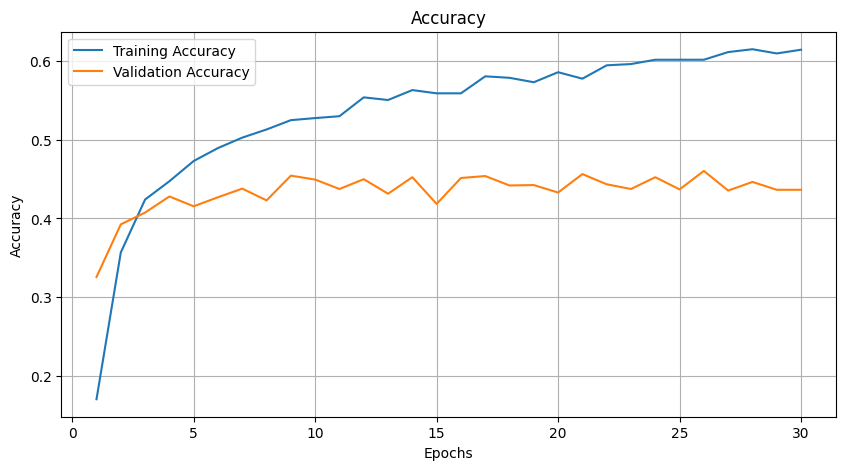

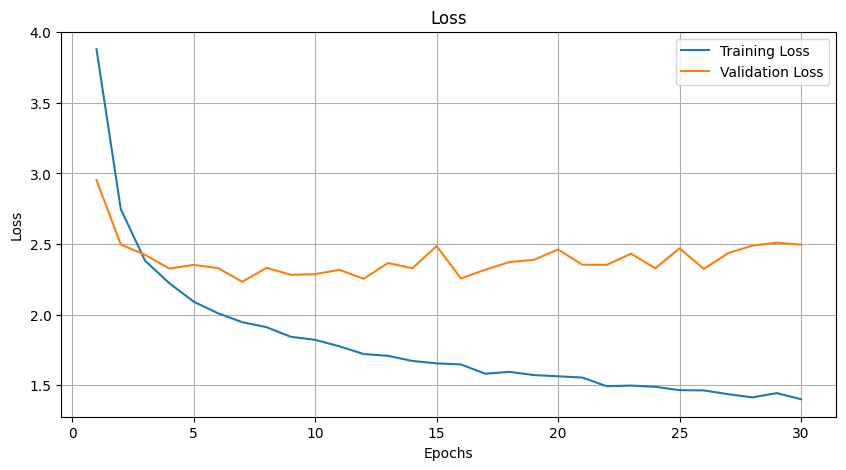

In [12]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)


Epoch [1/30]: 100%|██████████| 250/250 [00:53<00:00,  4.66it/s, Batch Loss=2.28, Running Loss=1.42, Accuracy=61.5]


Fine-Tune Epoch 1/30
Train Loss: 1.4234, Train Acc: 0.6148
Val Loss: 2.3970, Val Acc: 0.4485


Epoch [2/30]: 100%|██████████| 250/250 [01:24<00:00,  2.95it/s, Batch Loss=1.22, Running Loss=1.36, Accuracy=62.5]


Fine-Tune Epoch 2/30
Train Loss: 1.3603, Train Acc: 0.6254
Val Loss: 2.4700, Val Acc: 0.4410


Epoch [3/30]: 100%|██████████| 250/250 [00:48<00:00,  5.18it/s, Batch Loss=0.929, Running Loss=1.38, Accuracy=62]


Fine-Tune Epoch 3/30
Train Loss: 1.3809, Train Acc: 0.6200
Val Loss: 2.5047, Val Acc: 0.4360


Epoch [4/30]: 100%|██████████| 250/250 [00:48<00:00,  5.13it/s, Batch Loss=1.41, Running Loss=1.35, Accuracy=63.3]


Fine-Tune Epoch 4/30
Train Loss: 1.3462, Train Acc: 0.6332
Val Loss: 2.4080, Val Acc: 0.4610
Saved best finetuned model!


Epoch [5/30]: 100%|██████████| 250/250 [00:49<00:00,  5.01it/s, Batch Loss=0.797, Running Loss=1.32, Accuracy=63.7]


Fine-Tune Epoch 5/30
Train Loss: 1.3237, Train Acc: 0.6368
Val Loss: 2.5553, Val Acc: 0.4335


Epoch [6/30]: 100%|██████████| 250/250 [01:22<00:00,  3.02it/s, Batch Loss=1.24, Running Loss=1.36, Accuracy=62.4]


Fine-Tune Epoch 6/30
Train Loss: 1.3602, Train Acc: 0.6236
Val Loss: 2.4783, Val Acc: 0.4445


Epoch [7/30]: 100%|██████████| 250/250 [00:55<00:00,  4.48it/s, Batch Loss=1.76, Running Loss=1.31, Accuracy=63.5]


Fine-Tune Epoch 7/30
Train Loss: 1.3131, Train Acc: 0.6349
Val Loss: 2.4406, Val Acc: 0.4445


Epoch [8/30]: 100%|██████████| 250/250 [00:48<00:00,  5.19it/s, Batch Loss=1.16, Running Loss=1.31, Accuracy=63.3]


Fine-Tune Epoch 8/30
Train Loss: 1.3145, Train Acc: 0.6334
Val Loss: 2.5016, Val Acc: 0.4450


Epoch [9/30]: 100%|██████████| 250/250 [00:48<00:00,  5.17it/s, Batch Loss=1.22, Running Loss=1.31, Accuracy=63.9]


Fine-Tune Epoch 9/30
Train Loss: 1.3146, Train Acc: 0.6389
Val Loss: 2.4642, Val Acc: 0.4580


Epoch [10/30]: 100%|██████████| 250/250 [00:47<00:00,  5.22it/s, Batch Loss=0.998, Running Loss=1.26, Accuracy=64.8]


Fine-Tune Epoch 10/30
Train Loss: 1.2630, Train Acc: 0.6478
Val Loss: 2.4769, Val Acc: 0.4375


Epoch [11/30]: 100%|██████████| 250/250 [00:48<00:00,  5.18it/s, Batch Loss=1.4, Running Loss=1.27, Accuracy=64.8]


Fine-Tune Epoch 11/30
Train Loss: 1.2685, Train Acc: 0.6481
Val Loss: 2.4951, Val Acc: 0.4485


Epoch [12/30]: 100%|██████████| 250/250 [00:49<00:00,  5.06it/s, Batch Loss=1.5, Running Loss=1.29, Accuracy=64.1]


Fine-Tune Epoch 12/30
Train Loss: 1.2949, Train Acc: 0.6406
Val Loss: 2.4410, Val Acc: 0.4545


Epoch [13/30]: 100%|██████████| 250/250 [00:49<00:00,  5.05it/s, Batch Loss=1.71, Running Loss=1.25, Accuracy=65.2]


Fine-Tune Epoch 13/30
Train Loss: 1.2541, Train Acc: 0.6521
Val Loss: 2.5181, Val Acc: 0.4420


Epoch [14/30]: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s, Batch Loss=1.02, Running Loss=1.24, Accuracy=64.3]


Fine-Tune Epoch 14/30
Train Loss: 1.2430, Train Acc: 0.6432
Val Loss: 2.5193, Val Acc: 0.4510


Epoch [15/30]: 100%|██████████| 250/250 [00:49<00:00,  5.07it/s, Batch Loss=1.5, Running Loss=1.21, Accuracy=66.3]


Fine-Tune Epoch 15/30
Train Loss: 1.2144, Train Acc: 0.6629
Val Loss: 2.5722, Val Acc: 0.4470


Epoch [16/30]: 100%|██████████| 250/250 [00:48<00:00,  5.14it/s, Batch Loss=1.53, Running Loss=1.25, Accuracy=65]


Fine-Tune Epoch 16/30
Train Loss: 1.2478, Train Acc: 0.6495
Val Loss: 2.5314, Val Acc: 0.4340


Epoch [17/30]: 100%|██████████| 250/250 [00:47<00:00,  5.22it/s, Batch Loss=1.39, Running Loss=1.23, Accuracy=65.1]


Fine-Tune Epoch 17/30
Train Loss: 1.2303, Train Acc: 0.6514
Val Loss: 2.4492, Val Acc: 0.4560


Epoch [18/30]: 100%|██████████| 250/250 [00:48<00:00,  5.19it/s, Batch Loss=1.29, Running Loss=1.22, Accuracy=65.3]


Fine-Tune Epoch 18/30
Train Loss: 1.2242, Train Acc: 0.6535
Val Loss: 2.4451, Val Acc: 0.4575


Epoch [19/30]: 100%|██████████| 250/250 [00:48<00:00,  5.19it/s, Batch Loss=1.36, Running Loss=1.23, Accuracy=65.4]


Fine-Tune Epoch 19/30
Train Loss: 1.2265, Train Acc: 0.6539
Val Loss: 2.5636, Val Acc: 0.4370


Epoch [20/30]: 100%|██████████| 250/250 [00:47<00:00,  5.24it/s, Batch Loss=1.07, Running Loss=1.2, Accuracy=65.8]


Fine-Tune Epoch 20/30
Train Loss: 1.2004, Train Acc: 0.6575
Val Loss: 2.5012, Val Acc: 0.4505


Epoch [21/30]: 100%|██████████| 250/250 [00:47<00:00,  5.21it/s, Batch Loss=1.3, Running Loss=1.21, Accuracy=65.6]


Fine-Tune Epoch 21/30
Train Loss: 1.2099, Train Acc: 0.6564
Val Loss: 2.5014, Val Acc: 0.4525


Epoch [22/30]: 100%|██████████| 250/250 [00:49<00:00,  5.08it/s, Batch Loss=1.4, Running Loss=1.18, Accuracy=66.7]


Fine-Tune Epoch 22/30
Train Loss: 1.1835, Train Acc: 0.6671
Val Loss: 2.5633, Val Acc: 0.4530


Epoch [23/30]: 100%|██████████| 250/250 [00:49<00:00,  5.06it/s, Batch Loss=1.03, Running Loss=1.17, Accuracy=66.8]


Fine-Tune Epoch 23/30
Train Loss: 1.1691, Train Acc: 0.6676
Val Loss: 2.5927, Val Acc: 0.4470


Epoch [24/30]: 100%|██████████| 250/250 [00:48<00:00,  5.13it/s, Batch Loss=0.817, Running Loss=1.2, Accuracy=66.6]


Fine-Tune Epoch 24/30
Train Loss: 1.1968, Train Acc: 0.6661
Val Loss: 2.5708, Val Acc: 0.4545


Epoch [25/30]: 100%|██████████| 250/250 [00:47<00:00,  5.23it/s, Batch Loss=0.736, Running Loss=1.16, Accuracy=67.1]


Fine-Tune Epoch 25/30
Train Loss: 1.1605, Train Acc: 0.6710
Val Loss: 2.5196, Val Acc: 0.4535


Epoch [26/30]: 100%|██████████| 250/250 [00:47<00:00,  5.22it/s, Batch Loss=1.23, Running Loss=1.16, Accuracy=66.6]


Fine-Tune Epoch 26/30
Train Loss: 1.1647, Train Acc: 0.6656
Val Loss: 2.5301, Val Acc: 0.4535


Epoch [27/30]: 100%|██████████| 250/250 [00:48<00:00,  5.20it/s, Batch Loss=0.89, Running Loss=1.15, Accuracy=67.4]


Fine-Tune Epoch 27/30
Train Loss: 1.1514, Train Acc: 0.6741
Val Loss: 2.4790, Val Acc: 0.4565


Epoch [28/30]: 100%|██████████| 250/250 [00:47<00:00,  5.22it/s, Batch Loss=1.64, Running Loss=1.11, Accuracy=67.9]


Fine-Tune Epoch 28/30
Train Loss: 1.1084, Train Acc: 0.6789
Val Loss: 2.5183, Val Acc: 0.4580


Epoch [29/30]: 100%|██████████| 250/250 [01:08<00:00,  3.67it/s, Batch Loss=0.85, Running Loss=1.12, Accuracy=67.9]


Fine-Tune Epoch 29/30
Train Loss: 1.1240, Train Acc: 0.6789
Val Loss: 2.5621, Val Acc: 0.4520


Epoch [30/30]: 100%|██████████| 250/250 [01:06<00:00,  3.78it/s, Batch Loss=0.946, Running Loss=1.16, Accuracy=67]


Fine-Tune Epoch 30/30
Train Loss: 1.1554, Train Acc: 0.6700
Val Loss: 2.5046, Val Acc: 0.4570


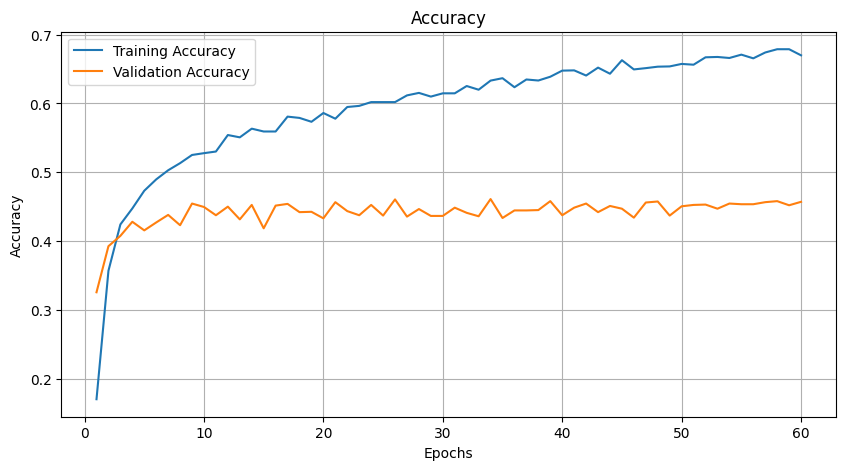

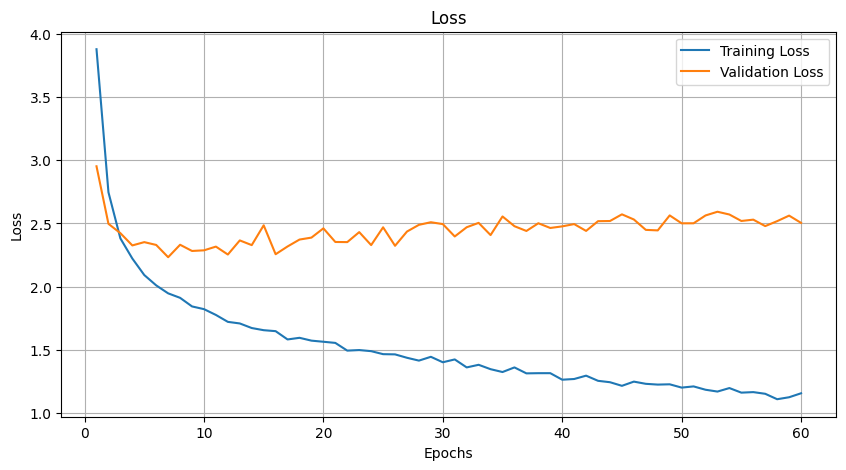

In [13]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers (modify based on ResNet structure)
for param in model.fc.parameters():
    param.requires_grad = True


# Reinitialize the optimizer for fine-tuning
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Fine-tuning loop
fine_tune_epochs = 30
for epoch in range(1, fine_tune_epochs + 1):  # Start from 1 for better logs
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, fine_tune_epochs)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fine-Tune Epoch {epoch}/{fine_tune_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, "best_model_finetuned.pth")
        print("Saved best finetuned model!")

# Plot the training and validation history
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [14]:
from PIL import Image

def predict_image(image_path, model, class_labels):
    model.eval()
    img = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)  # Prepare tensor
    with torch.no_grad():  # disable gradient computation stuff
        outputs = model(img_tensor)  # Predict
        _, predicted_index = outputs.max(1)  # Get the class index
    return class_labels[predicted_index.item()]

### **Prediction of 3 Random Images from Dataset**

In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def show_and_predict_dataset_images(dataset, model, class_labels, num_images=3):
    model.eval()

    selected_indexes= random.sample(range(len(dataset)), num_images)
    selected_samples = [dataset[index] for index in selected_indexes]

    #Prep the figure for showing images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (image, true_label) in enumerate(selected_samples):
        img_pil = to_pil_image(image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                       torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1))  # Denormalize inline

        #prediction
        with torch.no_grad():
            image = image.unsqueeze(0).to(device)  #Add batch dimension and move to device (if cuda)
            outputs = model(image)
            _, predicted_idx = outputs.max(1)
            predicted_label = class_labels[predicted_idx.item()]

        axs[i].imshow(img_pil)
        axs[i].set_title(f"Prediction: {predicted_label}\nTruth: {class_labels[true_label]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


<ipython-input-23-87ff6193a1b0>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)


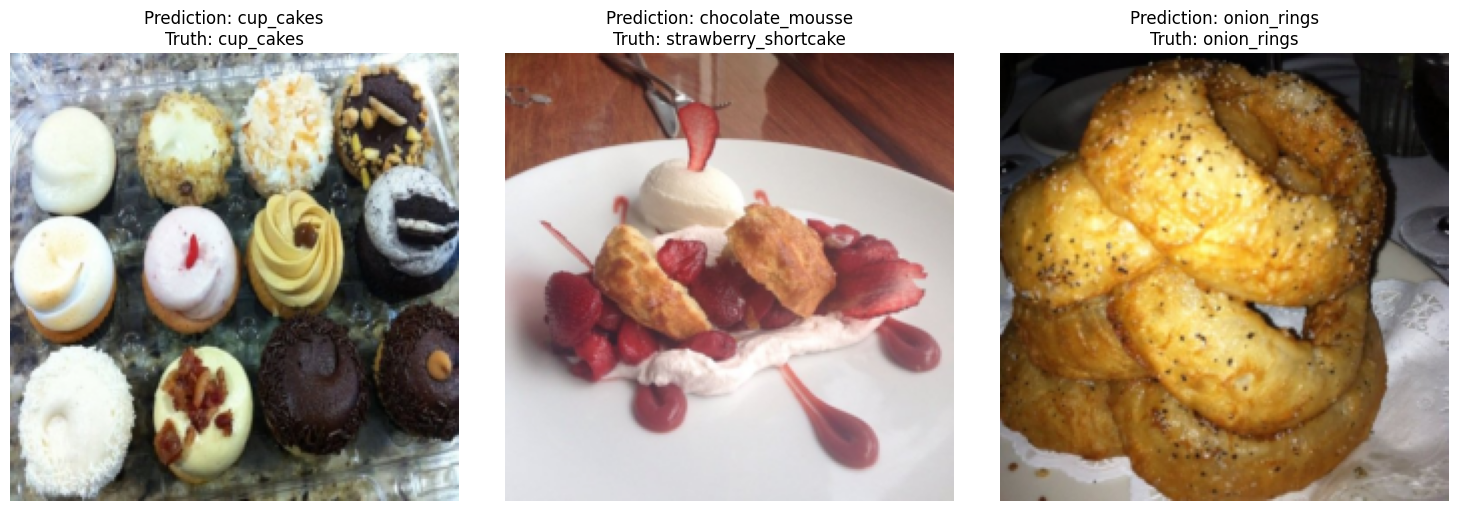

In [23]:
classes = test_dataset.classes
num_classes = len(classes)


model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Load the saved checkpoint
checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
show_and_predict_dataset_images(test_dataset, model, classes, num_images=3)


### **Prediction of 3 Random Images from Google**

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

num_classes = 101

classes = train_dataset.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Load the model
checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


pred_class = predict_image("/content/cake.jpg", model, classes)
print("Predicted class:", pred_class)
getMacros(pred_class)


pred_class = predict_image("/content/baklava.jpg", model, classes)
print("Predicted class:", pred_class)
getMacros(pred_class)

pred_class = predict_image("/content/breakfastburrito.webp", model, classes)
print("Predicted class:", pred_class)
getMacros(pred_class)

<ipython-input-21-429e6355034e>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)


Predicted class: red_velvet_cake
Predicted class: macarons
Predicted class: breakfast_burrito


In [ ]:
food_macros = {
    'apple_pie': {'calories': 320, 'protein': 2, 'carbs': 51, 'fat': 14},
    'baby_back_ribs': {'calories': 400, 'protein': 30, 'carbs': 8, 'fat': 30},
    'baklava': {'calories': 330, 'protein': 4, 'carbs': 34, 'fat': 20},
    'beef_carpaccio': {'calories': 250, 'protein': 30, 'carbs': 0, 'fat': 15},
    'beef_tartare': {'calories': 200, 'protein': 26, 'carbs': 0, 'fat': 10},
    'beet_salad': {'calories': 180, 'protein': 4, 'carbs': 25, 'fat': 8},
    'beignets': {'calories': 250, 'protein': 5, 'carbs': 35, 'fat': 12},
    'bibimbap': {'calories': 500, 'protein': 22, 'carbs': 60, 'fat': 18},
    'bread_pudding': {'calories': 320, 'protein': 6, 'carbs': 50, 'fat': 10},
    'breakfast_burrito': {'calories': 500, 'protein': 25, 'carbs': 45, 'fat': 25},
    'bruschetta': {'calories': 260, 'protein': 8, 'carbs': 35, 'fat': 10},
    'caesar_salad': {'calories': 350, 'protein': 15, 'carbs': 15, 'fat': 25},
    'cannoli': {'calories': 300, 'protein': 5, 'carbs': 30, 'fat': 18},
    'caprese_salad': {'calories': 250, 'protein': 7, 'carbs': 10, 'fat': 20},
    'carrot_cake': {'calories': 400, 'protein': 5, 'carbs': 60, 'fat': 15},
    'ceviche': {'calories': 200, 'protein': 18, 'carbs': 10, 'fat': 5},
    'cheesecake': {'calories': 300, 'protein': 6, 'carbs': 32, 'fat': 18},
    'cheese_plate': {'calories': 450, 'protein': 25, 'carbs': 5, 'fat': 36},
    'chicken_curry': {'calories': 420, 'protein': 30, 'carbs': 20, 'fat': 28},
    'chicken_quesadilla': {'calories': 350, 'protein': 20, 'carbs': 30, 'fat': 15},
    'chicken_wings': {'calories': 400, 'protein': 30, 'carbs': 0, 'fat': 28},
    'chocolate_cake': {'calories': 350, 'protein': 5, 'carbs': 55, 'fat': 15},
    'chocolate_mousse': {'calories': 280, 'protein': 4, 'carbs': 28, 'fat': 18},
    'churros': {'calories': 200, 'protein': 2, 'carbs': 36, 'fat': 8},
    'clam_chowder': {'calories': 200, 'protein': 15, 'carbs': 20, 'fat': 8},
    'club_sandwich': {'calories': 450, 'protein': 25, 'carbs': 36, 'fat': 22},
    'crab_cakes': {'calories': 200, 'protein': 15, 'carbs': 10, 'fat': 12},
    'creme_brulee': {'calories': 350, 'protein': 5, 'carbs': 30, 'fat': 20},
    'croque_madame': {'calories': 500, 'protein': 25, 'carbs': 40, 'fat': 30},
    'cup_cakes': {'calories': 350, 'protein': 3, 'carbs': 55, 'fat': 14},
    'deviled_eggs': {'calories': 200, 'protein': 12, 'carbs': 2, 'fat': 16},
    'donuts': {'calories': 300, 'protein': 3, 'carbs': 38, 'fat': 15},
    'dumplings': {'calories': 250, 'protein': 10, 'carbs': 35, 'fat': 7},
    'edamame': {'calories': 200, 'protein': 18, 'carbs': 14, 'fat': 8},
    'eggs_benedict': {'calories': 400, 'protein': 20, 'carbs': 30, 'fat': 24},
    'escargots': {'calories': 150, 'protein': 22, 'carbs': 0, 'fat': 7},
    'falafel': {'calories': 320, 'protein': 13, 'carbs': 40, 'fat': 15},
    'filet_mignon': {'calories': 400, 'protein': 30, 'carbs': 0, 'fat': 22},
    'fish_and_chips': {'calories': 600, 'protein': 30, 'carbs': 70, 'fat': 25},
    'foie_gras': {'calories': 300, 'protein': 12, 'carbs': 0, 'fat': 28},
    'french_fries': {'calories': 365, 'protein': 4, 'carbs': 63, 'fat': 19},
    'french_onion_soup': {'calories': 250, 'protein': 5, 'carbs': 30, 'fat': 8},
    'french_toast': {'calories': 300, 'protein': 10, 'carbs': 50, 'fat': 10},
    'fried_calamari': {'calories': 300, 'protein': 10, 'carbs': 20, 'fat': 20},
    'fried_rice': {'calories': 350, 'protein': 10, 'carbs': 55, 'fat': 12},
    'frozen_yogurt': {'calories': 150, 'protein': 4, 'carbs': 30, 'fat': 1},
    'garlic_bread': {'calories': 250, 'protein': 6, 'carbs': 31, 'fat': 12},
    'gnocchi': {'calories': 250, 'protein': 8, 'carbs': 50, 'fat': 2},
    'greek_salad': {'calories': 200, 'protein': 5, 'carbs': 10, 'fat': 15},
    'grilled_cheese_sandwich': {'calories': 300, 'protein': 12, 'carbs': 30, 'fat': 18},
    'grilled_salmon': {'calories': 300, 'protein': 30, 'carbs': 0, 'fat': 20},
    'guacamole': {'calories': 230, 'protein': 3, 'carbs': 12, 'fat': 22},
    'gyoza': {'calories': 100, 'protein': 4, 'carbs': 16, 'fat': 4},
    'hamburger': {'calories': 354, 'protein': 17, 'carbs': 32, 'fat': 22},
    'hot_and_sour_soup': {'calories': 100, 'protein': 6, 'carbs': 10, 'fat': 4},
    'hot_dog': {'calories': 150, 'protein': 5, 'carbs': 2, 'fat': 13},
    'huevos_rancheros': {'calories': 300, 'protein': 15, 'carbs': 30, 'fat': 15},
    'hummus': {'calories': 200, 'protein': 8, 'carbs': 25, 'fat': 10},
    'ice_cream': {'calories': 200, 'protein': 4, 'carbs': 30, 'fat': 10},
    'lasagna': {'calories': 450, 'protein': 25, 'carbs': 50, 'fat': 20},
    'lobster_bisque': {'calories': 350, 'protein': 15, 'carbs': 18, 'fat': 25},
    'lobster_roll_sandwich': {'calories': 500, 'protein': 25, 'carbs': 30, 'fat': 30},
    'macaroni_and_cheese': {'calories': 300, 'protein': 10, 'carbs': 45, 'fat': 12},
    'macarons': {'calories': 100, 'protein': 1, 'carbs': 15, 'fat': 4},
    'miso_soup': {'calories': 40, 'protein': 3, 'carbs': 6, 'fat': 1},
    'mussels': {'calories': 150, 'protein': 20, 'carbs': 10, 'fat': 4},
    'nachos': {'calories': 420, 'protein': 12, 'carbs': 56, 'fat': 22},
    'omelette': {'calories': 150, 'protein': 10, 'carbs': 2, 'fat': 11},
    'onion_rings': {'calories': 300, 'protein': 4, 'carbs': 48, 'fat': 14},
    'oysters': {'calories': 50, 'protein': 6, 'carbs': 2, 'fat': 2},
    'pad_thai': {'calories': 400, 'protein': 18, 'carbs': 70, 'fat': 12},
    'paella': {'calories': 400, 'protein': 25, 'carbs': 45, 'fat': 15},
    'pancakes': {'calories': 350, 'protein': 8, 'carbs': 50, 'fat': 14},
    'panna_cotta': {'calories': 250, 'protein': 4, 'carbs': 30, 'fat': 12},
    'peking_duck': {'calories': 500, 'protein': 25, 'carbs': 15, 'fat': 38},
    'pho': {'calories': 350, 'protein': 25, 'carbs': 50, 'fat': 10},
    'pizza': {'calories': 285, 'protein': 12, 'carbs': 36, 'fat': 10},
    'pork_chop': {'calories': 350, 'protein': 30, 'carbs': 0, 'fat': 22},
    'poutine': {'calories': 600, 'protein': 15, 'carbs': 70, 'fat': 36},
    'prime_rib': {'calories': 450, 'protein': 40, 'carbs': 0, 'fat': 30},
    'pulled_pork_sandwich': {'calories': 400, 'protein': 25, 'carbs': 40, 'fat': 20},
    'ramen': {'calories': 400, 'protein': 20, 'carbs': 50, 'fat': 15},
    'ravioli': {'calories': 300, 'protein': 12, 'carbs': 40, 'fat': 10},
    'red_velvet_cake': {'calories': 350, 'protein': 5, 'carbs': 55, 'fat': 15},
    'risotto': {'calories': 350, 'protein': 10, 'carbs': 60, 'fat': 10},
    'samosa': {'calories': 200, 'protein': 5, 'carbs': 30, 'fat': 10},
    'sashimi': {'calories': 100, 'protein': 20, 'carbs': 0, 'fat': 5},
    'scallops': {'calories': 250, 'protein': 36, 'carbs': 5, 'fat': 10},
    'seaweed_salad': {'calories': 70, 'protein': 1, 'carbs': 14, 'fat': 2},
    'shrimp_and_grits': {'calories': 400, 'protein': 25, 'carbs': 55, 'fat': 15},
    'spaghetti_bolognese': {'calories': 500, 'protein': 20, 'carbs': 70, 'fat': 15},
    'spaghetti_carbonara': {'calories': 600, 'protein': 25, 'carbs': 75, 'fat': 25},
    'spring_rolls': {'calories': 200, 'protein': 5, 'carbs': 30, 'fat': 8},
    'steak': {'calories': 450, 'protein': 40, 'carbs': 0, 'fat': 30},
    'strawberry_shortcake': {'calories': 350, 'protein': 5, 'carbs': 60, 'fat': 12},
    'sushi': {'calories': 200, 'protein': 8, 'carbs': 40, 'fat': 2},
    'tacos': {'calories': 250, 'protein': 15, 'carbs': 20, 'fat': 12},
    'takoyaki': {'calories': 250, 'protein': 10, 'carbs': 30, 'fat': 12},
    'tiramisu': {'calories': 400, 'protein': 6, 'carbs': 46, 'fat': 26},
    'tuna_tartare': {'calories': 150, 'protein': 20, 'carbs': 0, 'fat': 7},
    'waffles': {'calories': 300, 'protein': 8, 'carbs': 50, 'fat': 12},
}
def getMacros(food):
      macros = food_macros.get(food.lower(), None)
      if macros:
        print(f'Macronutrients for one serving of {food}: {macros}')
        return macros
      else:
        print("Food item not found.")
        return None